# RNN Model for Whatsapp's Chat

In [1]:
#Import Required Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import sys
import string
from collections import Counter
import matplotlib.pyplot as plt
import re

In [2]:
vocab = {}

In [3]:
def initializeVocabulary():
    unkToken = '<UNK>'
    #create another vocab inside vocab -> text to index
    vocab['t_2_i'] = {}
    #create another vocab inside vocab -> index to text
    vocab['i_2_t'] = {}
    # Add token in key 'unkToken' = '<UNK>'
    vocab['unkToken'] = unkToken
    # call function 'addToken()' that return token index
    idx = addToken(unkToken)
    vocab['unkTokenIdx'] = idx

In [4]:
def addToken(token):
    # if token already in vocab then just return index
    if token in vocab['t_2_i']:
        idx = vocab['t_2_i'][token]
    else:
        # create index for new tokken --> simply new index == len(vocab) /*last number*/
        idx = len(vocab['t_2_i'])
        vocab['t_2_i'][token] = idx
        vocab['i_2_t'][idx] = token
    return idx

In [5]:
def addManyTokens(tokens):
    idxes = [addToken(token) for token in tokens]
    return idxes

In [6]:
def lookUpToken(token):
    return vocab['t_2_i'].get(token,vocab['unkTokenIdx'])

In [7]:
def lookUpIndex(idx):
    if idx not in vocab['i_2_t']:
        raise KeyError("the index (%d) is not there" % idx)
    return vocab['i_2_t'][idx]

In [8]:
def vocabularyFromDataFrame(df,cutoff=5):
    initializeVocabulary()
    wordCounts = Counter()
    for r in df.Message:
        for word in re.split('\W+',r):
            wordCounts[word] += 1
    for word,count in wordCounts.items():
        if count > cutoff:
            addToken(word)

In [9]:
def vocabularyFromCorpus(Corpus,cutoff=2):
    initializeVocabulary()
    wordCounts = Counter()
    for doc in Corpus:
        for word in re.split('\W+',doc):
            wordCounts[word] += 1
    for word,count in wordCounts.items():
        if count > cutoff:
            addToken(word)

In [10]:
def oneHotVector(token,N):
    oneHot = np.zeros((N,1))
    oneHot[lookUpToken(token)] = 1
    return oneHot

In [17]:
df = pd.read_excel('Whatsapp_chat_Data.xlsx')
# Drop NaN values in Dataframe
df = df.dropna()
# Change Column value --> from 'fear' to 'Fear' :)
#df["Mode"].replace({"Angry ": "Angry", "fear": "Fear",}, inplace=True)

# Change Column value --> from 'fear' to 'Fear' :)
df["Mode"].replace({"Normal": "Positive", "Happy": "Positive", "Love": "Positive",}, inplace=True)
df["Mode"].replace({"Angry": "Negative", "Fear": "Negative", "Sad": "Negative",}, inplace=True)

In [18]:
# Get the unique values of 'Mode' column
df.Mode.unique()

array(['Negative', 'Positive'], dtype=object)

In [20]:
df['Mode'].value_counts()

Positive    1124
Negative     793
Name: Mode, dtype: int64

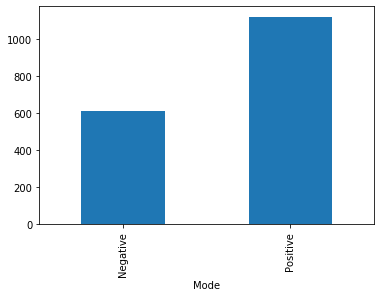

In [19]:
# a simple line plot
#df.plot(kind='bar',x='Mode',y='Message')
df.groupby('Mode')['Message'].nunique().plot(kind='bar')
plt.show()

In [21]:
df.head(5)

,Mode,Message
0,Negative,Hmme na pagal ho chuki har teacher ki mintaien...
1,Negative,Or phir teachers k krny waly kam b me he kron
2,Negative,Allah kry maan jay ab bus
3,Negative,Abhe aca ki assignments rehti hain
5,Negative,Ab Eid tu guzarny dein sakoon se


In [24]:
vocabularyFromDataFrame(df, cutoff=2)

In [25]:
len(vocab['t_2_i'])

837

In [26]:
lookUpIndex(100)

'uss'

In [27]:
def vectorize(message):
    isFirst = True
    for token in message.split(" "):
        if token not in string.punctuation:
            oneHot = np.zeros((len(vocab['t_2_i']),1))
            oneHot[lookUpToken(token)] = 1
            if isFirst:
                xF = oneHot
                isFirst = False
            else:
                xF = np.hstack((xF,oneHot))
    return xF

In [28]:
xF = vectorize(df['Message'][1])

In [ ]:
## We just use oneHOt emedding ... 
##for better choice you may choice word to vector emedding and so on ....

In [29]:
xF.shape
#df['Message'][1]

(837, 11)

In [39]:
smallDf_pos = df[df['Mode']=='Positive'].iloc[:5]
smallDf_neg = df[df['Mode']=='Negative'].iloc[:5]
df_small = pd.concat([smallDf_pos,smallDf_neg], axis=0)

In [79]:
#vocabularyFromDataFrame(df_small, cutoff=0)

In [74]:
df_small

,Mode,Message
2,Positive,Ya puchna ya tha k Shair kisi b traha ka send ...
3,Positive,Han g phir to any dain gy per ap k any k bgair...
4,Positive,Everyone please bs kro yr
6,Positive,Itny ap sary Fawad khan rehty ni
8,Positive,ok then MOV
0,Negative,Tu to chup kr ja desh
1,Negative,Bush kr de bush
5,Negative,Tra GB delete ni howa kia abho tak
10,Negative,Gustakhi ki mafi
15,Negative,tum tu barhana chahty thy teli lga k gaib hat ...


In [30]:
numFeatures = len(vocab['t_2_i'])
hiddenUnits = 10
h0 = torch.tensor(np.zeros((hiddenUnits,1)))
Wx = torch.tensor(np.random.uniform(0,1,(hiddenUnits,numFeatures)),requires_grad=True)
Wh = torch.tensor(np.random.uniform(0,1,(hiddenUnits,hiddenUnits)),requires_grad=True)
Wy = torch.tensor(np.random.uniform(0,1,(1,hiddenUnits)),requires_grad=True)

In [31]:
print(Wh.shape,Wx.shape,Wy.shape,h0.shape)

torch.Size([10, 10]) torch.Size([10, 837]) torch.Size([1, 10]) torch.Size([10, 1])


In [32]:
def stepForward(xt,Wx,Wh,Wy,prevMemory):
    #x_frd = torch.matmul(Wx,torch.from_numpy(xt))
    #print("1: ",Wx.shape,torch.from_numpy(xt[:,np.newaxis]).shape)
    x_frd = torch.matmul(Wx,torch.from_numpy(xt[:,np.newaxis]))
    #print("2: ",Wh.shape,prevMemory.shape)
    h_frd = torch.matmul(Wh,prevMemory)
    ht = torch.tanh(x_frd+h_frd)
    yt_hat = torch.sigmoid(torch.matmul(Wy,ht))
    #yt_hat = F.softmax(torch.matmul(Wy,ht),dim=0)
    return ht,yt_hat

In [33]:
def fullForwardRNN(X,Wx,Wh,Wy,prevMemory):
    y_hat = []
    for t in range(X.shape[1]):
        ht,yt_hat = stepForward(X[:,t],Wx,Wh,Wy,prevMemory)
        prevMemory = ht
        y_hat = yt_hat
        #y_hat.append(yt_hat)
    return y_hat  

In [34]:
def computeLoss(y,y_hat):
    loss = 0
    for yi,yi_hat in zip(y,y_hat):
        if yi == 1:
            loss += -torch.log2(yi_hat)
        else:
            loss += -torch.log2(1-yi_hat)
        #Li = -torch.log2(yi_hat[yi==1])
        #loss += Li
    return loss/len(y)

In [35]:
def updateParams(Wx,Wh,Wy,dWx,dWh,dWy,lr):
    with torch.no_grad():
        Wx -= lr*dWx
        Wh -= lr*dWh
        Wy -= lr*dWy
    return Wx,Wh,Wy

In [36]:
def trainRNN(train_df,Wx,Wh,Wy,prevMemory,lr,nepoch):
    losses = []
    for epoch in range(nepoch):
        y,y_hat = [],[]
        for msg,mod in zip(train_df['Message'],train_df['Mode']):
            X = vectorize(msg)
            #print('``````````````~~~~~~~~~~~~~~~~~~`````````````````')
            #print(X.shape)
            yi_hat = fullForwardRNN(X,Wx,Wh,Wy,prevMemory)
            yi = 0
            if mod == 'Positive':
                yi = 1
            y.append(yi)
            y_hat.append(yi_hat)
                
        loss = computeLoss(y,y_hat)
        loss.backward()
        losses.append(loss)
        print("Loss after epoch=%d: %f" %(epoch,loss))
        sys.stdout.flush()
        dWx = Wx.grad.data
        dWh = Wh.grad.data
        dWy = Wy.grad.data
        Wx,Wh,Wy = updateParams(Wx,Wh,Wy,dWx,dWh,dWy,lr)
        Wx.grad.data.zero_()
        Wh.grad.data.zero_()
        Wy.grad.data.zero_()
    return Wx,Wh,Wy,losses

In [37]:
 Wx,Wh,Wy,losses = trainRNN(df,Wx,Wh,Wy,h0,0.001,200)

Loss after epoch=0: 2.957864
Loss after epoch=1: 2.954424
Loss after epoch=2: 2.950985
Loss after epoch=3: 2.947547
Loss after epoch=4: 2.944110
Loss after epoch=5: 2.940673
Loss after epoch=6: 2.937238
Loss after epoch=7: 2.933802
Loss after epoch=8: 2.930368
Loss after epoch=9: 2.926934
Loss after epoch=10: 2.923501
Loss after epoch=11: 2.920069
Loss after epoch=12: 2.916638
Loss after epoch=13: 2.913207
Loss after epoch=14: 2.909777
Loss after epoch=15: 2.906348
Loss after epoch=16: 2.902919
Loss after epoch=17: 2.899492
Loss after epoch=18: 2.896065
Loss after epoch=19: 2.892639
Loss after epoch=20: 2.889213
Loss after epoch=21: 2.885789
Loss after epoch=22: 2.882365
Loss after epoch=23: 2.878942
Loss after epoch=24: 2.875520
Loss after epoch=25: 2.872098
Loss after epoch=26: 2.868678
Loss after epoch=27: 2.865258
Loss after epoch=28: 2.861839
Loss after epoch=29: 2.858421
Loss after epoch=30: 2.855003
Loss after epoch=31: 2.851587
Loss after epoch=32: 2.848171
Loss after epoch=33:

In [169]:
# xF = vectorize(df['Message'][1])
# for t in range(xF.shape[1]):
#     print(xF[:,t]) # Coloumn
#     print("\n")
#     print(torch.from_numpy(xF[:,np.newaxis]).shape)

In [84]:
r = df_small['Message'].iloc[2]
y = df_small['Mode'].iloc[2]

In [85]:
r

'Or thank you'

In [86]:
X = vectorize(r)

In [87]:
y_hat = fullForwardRNN(X,Wx,Wh,Wy,h0) 

In [88]:
y_hat

tensor([[0.9778]], dtype=torch.float64, grad_fn=<SigmoidBackward>)

In [89]:
y

'Positive'

## RNN using pytorch

In [90]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader